In [72]:
# run ipython with this command: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import matplotlib
import brewer2mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout,Flatten
from keras.optimizers import SGD
from keras.activations import relu, tanh, elu
from keras.backend import clear_session
from keras.models import load_model

set3 = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
% matplotlib inline

In [73]:
train_data_x = pd.read_pickle('normalized_fer2013.pkl')
train_data_y = pd.read_pickle('normalized_fer2013_labels.pkl').astype(int)
test_data_x = pd.read_pickle('normalized_test_fer2013.pkl')
test_data_y = pd.read_pickle('normalized_test_fer2013_labels.pkl').astype(int)

In [74]:
train_data_x = train_data_x.as_matrix().reshape((-1,48,48,1))
test_data_x = test_data_x.as_matrix().reshape((-1,48,48,1))

In [75]:
emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
positive_emotes = [3, 5]
neutral = [6]
negative_emotes = [0, 1, 2, 4]

def lump_labels(label):
    if label in negative_emotes + neutral:
        return 0
    elif label in positive_emotes:
        return 1
    else:
        return 2
    

test_data_y2 = test_data_y.apply(lump_labels)

train_data_y2 = train_data_y.apply(lump_labels)

In [76]:
train_data_y = train_data_y.as_matrix()
test_data_y = test_data_y.as_matrix()

train_data_y2 = train_data_y2.as_matrix()
test_data_y2 = test_data_y2.as_matrix()

In [77]:
train_data_y = keras.utils.to_categorical(train_data_y, num_classes=7)
test_data_y = keras.utils.to_categorical(test_data_y, num_classes=7)

train_data_y2 = keras.utils.to_categorical(train_data_y2, num_classes=2)
test_data_y2 = keras.utils.to_categorical(test_data_y2, num_classes=2)

<font size = 20pt>__Training Process__</font>

In [ ]:
clear_session()
model = keras.models.Sequential()

model.add(Conv2D(16, (5,5), strides=(1,1),activation='elu',padding='same',input_shape=(48,48,1)))
model.add(Conv2D(16, (4,4), strides=(1,1),activation='elu',padding='same'))
model.add(Conv2D(16, (3,3), strides=(1,1),activation='elu',padding='same'))
model.add(Conv2D(16, (2,2), strides=(1,1),activation='elu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64,activation='tanh'))
model.add(Dense(32,activation='tanh'))
model.add(Dense(16,activation='tanh'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')

In [ ]:
# model.fit(train_data_x, train_data_y, validation_data=(test_data_x,test_data_y), epochs=100, batch_size=32)
model.fit(train_data_x, train_data_y2, validation_data=(test_data_x,test_data_y2), epochs=100, batch_size=32)

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
 6976/28709 [======>.......................] - ETA: 274s - loss: 0.6233 - acc: 0.6578

In [8]:
addr = "ADAM_16_16_16_16F64_32_16"

model.save(addr + ".h5")
model_json = model.to_json()
with open(addr + ".json", "w") as json_file:
    json_file.write(model_json)

<font size = 20pt>__Data Visualization__</font>

## Computer Vision

In [16]:
# load in the whole architecture, training methods, and weights with h5 file
addr = "ADAM_16_16_16_16F64_32_16"
model = load_model(addr + '.h5')

# # load the whole architecture stored in json and create model
# json_file = open(addr + '.json','r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into model from h5 file
# model.load_weights(addr + '.h5')


# evaluate model on test set
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(test_data_x, test_data_y, verbose=0)
print("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

model acc: 47.98%


In [17]:
# displays image[start:end]
def overview(start, end, X, pic_size):
    fig = plt.figure(figsize=(pic_size, pic_size))
    for i in range(start, end):
        input_img = X[i,:,:,:]
        ax = fig.add_subplot(10, 8,i+1)
        ax.imshow(input_img[:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

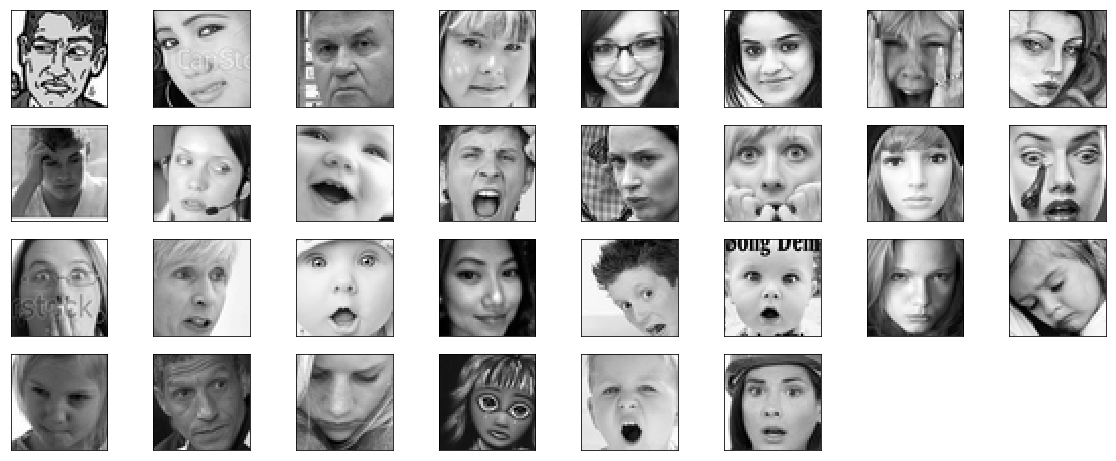

In [18]:
overview(0, 30, test_data_x, 16)

In [19]:
# display a single image
def single_image(target_image, X, pic_size):
    overview(target_image, target_image + 1, X, pic_size)

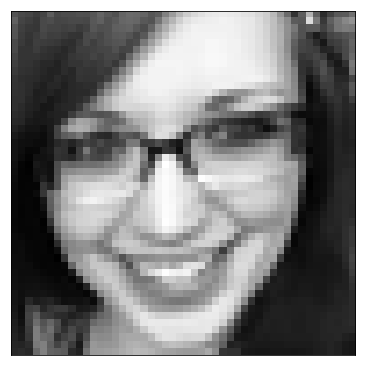

In [20]:
single_image(4, test_data_x, 50)

In [21]:
def plot_filter(layer, lay_index, pic_index, X):
    # create a cut-off CNN up to the nth layer
    temp_model = Sequential()
    for lay in range(lay_index + 1):
        temp_model.add(layers.deserialize({'class_name': layer[lay].__class__.__name__, 'config': layer[lay].get_config()}))
        temp_model.layers[lay].set_weights(layer[lay].get_weights())
    output = temp_model.predict(X)  # output the last layer (which is the desired output)

    # print out all output filters within the nth layer
    fig = plt.figure(figsize=(16, 16))
    print(output.shape)
    for i in range(len(output[pic_index][0][0])):
        input_img = output[pic_index,:,:,i]
        ax = fig.add_subplot((len(output[pic_index][0][0]) + 8) // 8, 8,i+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

# plot_filters(model.layers, 0, 0, test_data_x)
# plot_filters(model.layers, 1, 0, test_data_x)
# plot_filters(model.layers, 3, 1, test_data_x)

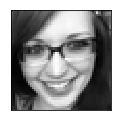



LAYER 1
(7178, 48, 48, 16)


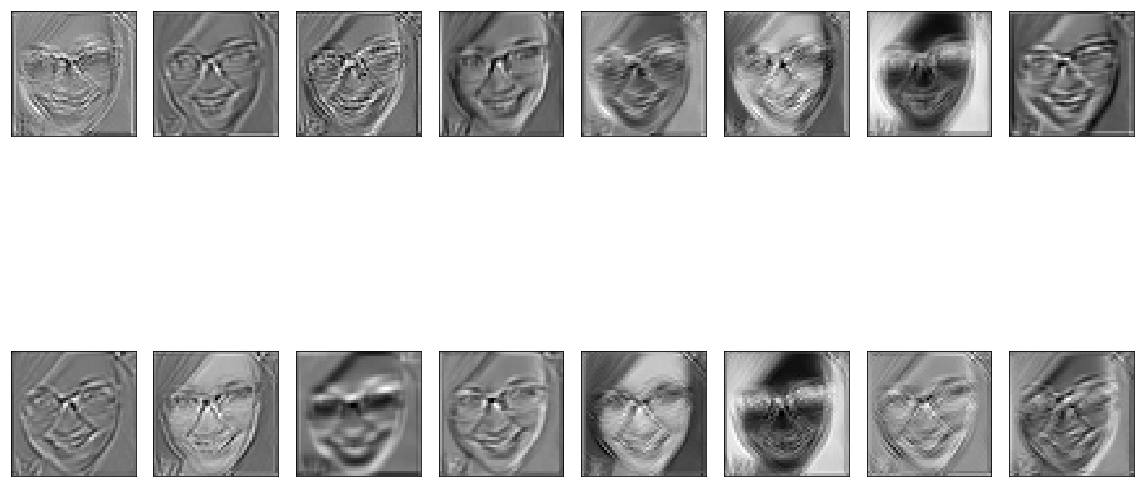



LAYER 2
(7178, 48, 48, 16)


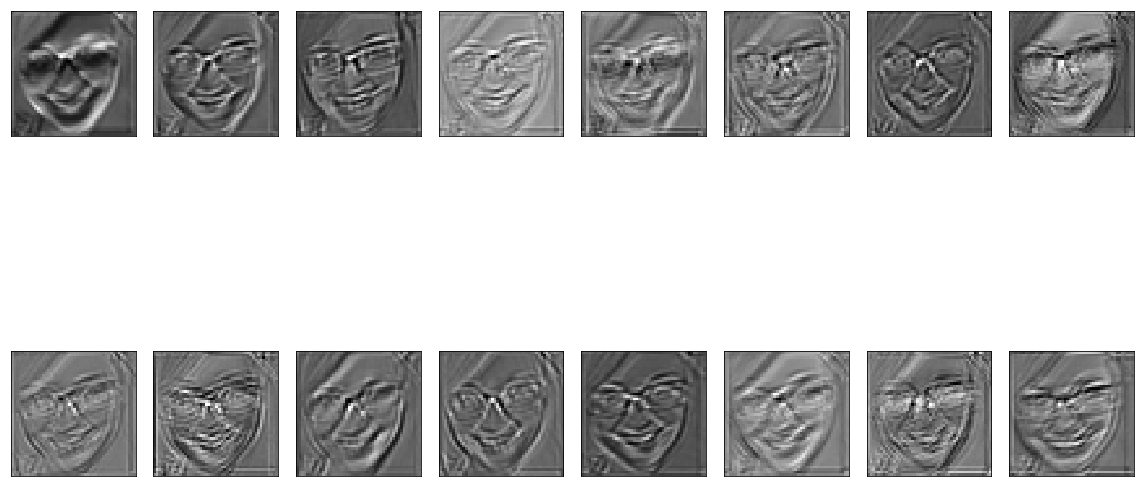



LAYER 3
(7178, 48, 48, 16)


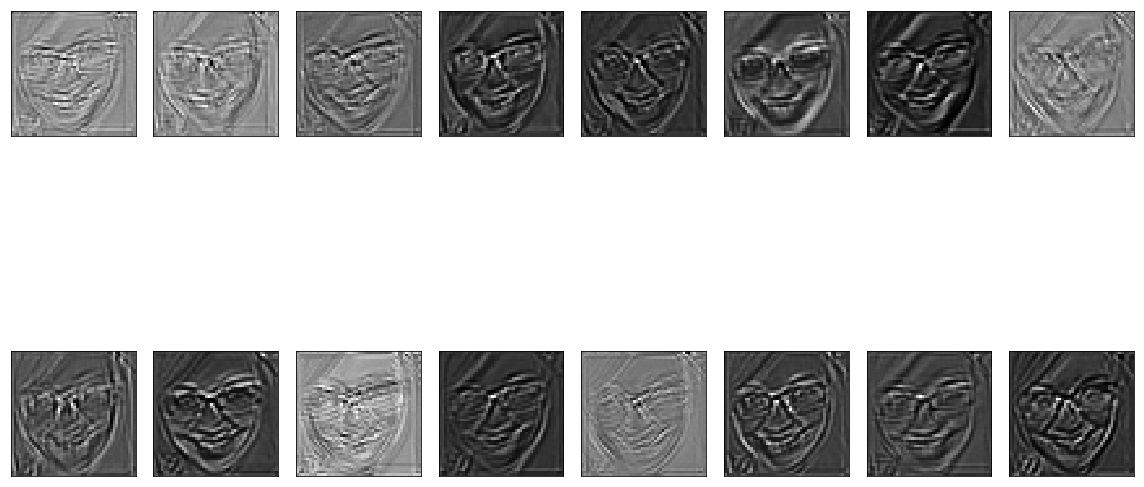



LAYER 4
(7178, 48, 48, 16)


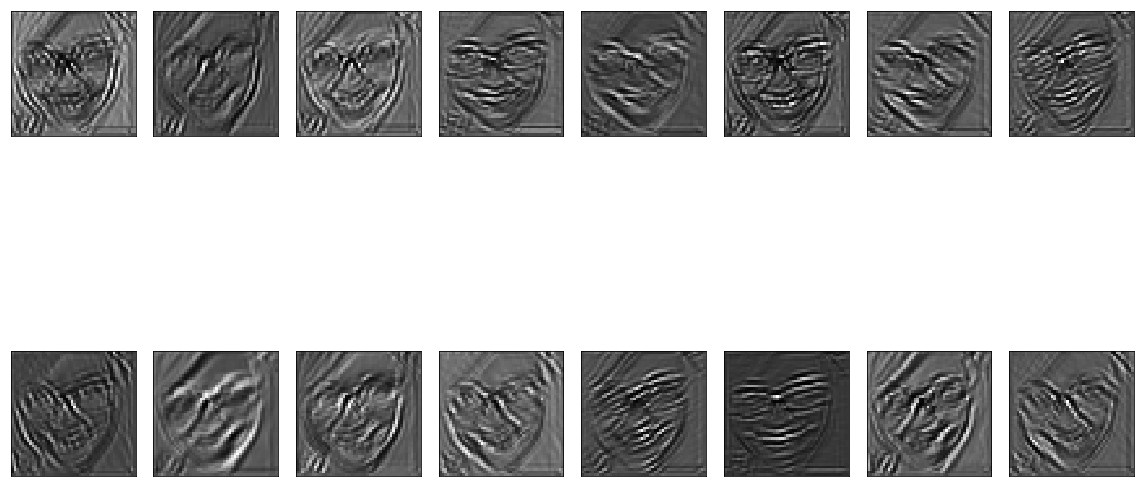



LAYER 5
(7178, 24, 24, 16)


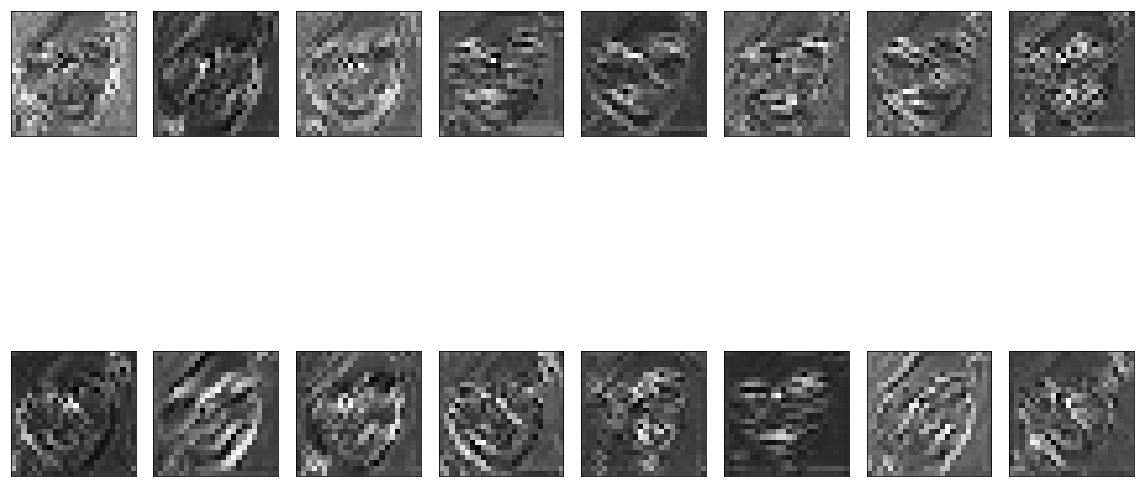

In [22]:
target_image = 4
single_image(target_image, test_data_x, 16)
for i in range(5):
    print("\n\nLAYER", i + 1)
    plot_filter(model.layers, i, target_image, test_data_x)

## Prediction Result

In [23]:
# prediction and true labels
y_prob = model.predict(test_data_x, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in test_data_y]

In [24]:
counts = np.bincount(y_pred)
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print([[x, y] for x, y in zip(labels, counts)])

[['angry', 963], ['disgust', 81], ['fear', 922], ['happy', 1730], ['sad', 1271], ['surprise', 877], ['neutral', 1334]]


In [25]:
def plot_subjects(start, end, X, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(16,16))
    emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i,:,:,:]
        ax = fig.add_subplot(10, 7, i+1)
        ax.imshow(input_img[:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [26]:
def plot_probs(start,end, X, y_prob):
    fig = plt.figure(figsize=(14,14))
    for i in range(start, end+1):
        input_img = X[i,:,:,:]
        ax = fig.add_subplot(10, 7, i+1)
        ax.bar(np.arange(0,7), y_prob[i], color=set3,alpha=0.5, edgecolor='black', linewidth=0.5)
        ax.set_xticks(np.arange(0,7,1))
        labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [27]:
def plot_subjects_with_probs(start, end, X, y_prob):
    iter = int((end - start)/7)
    for i in range(iter):
        plot_subjects(i*7,(i+1)*7-1, X, y_pred, y_true, title=False)
        plot_probs(i*7,(i+1)*7-1, X, y_prob)

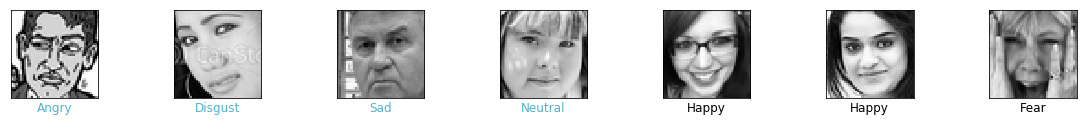

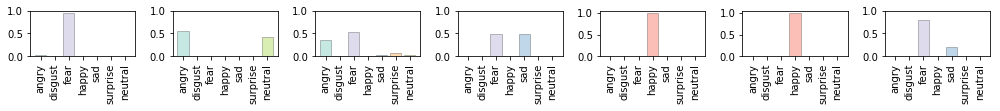

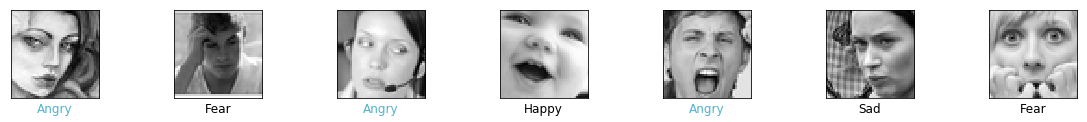

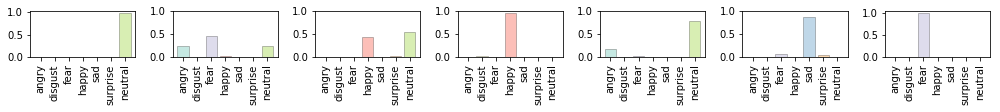

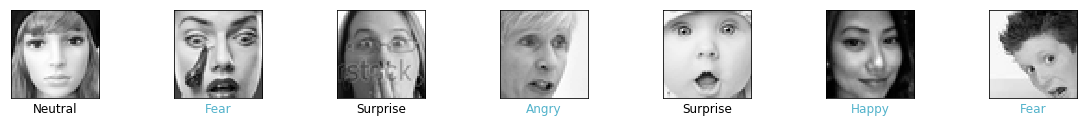

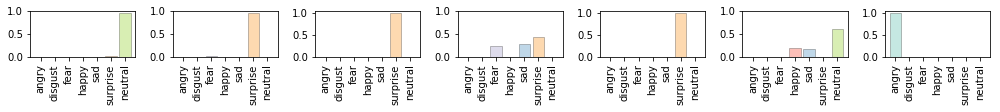

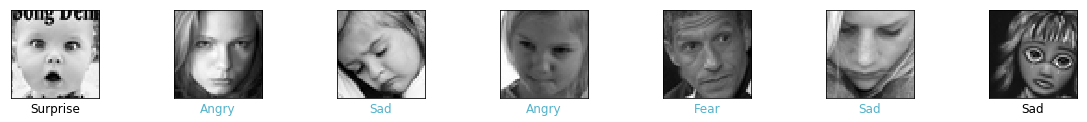

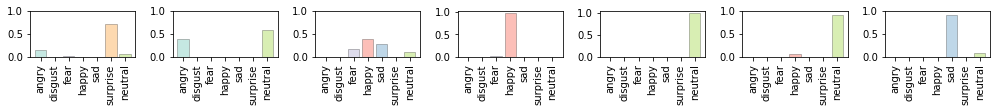

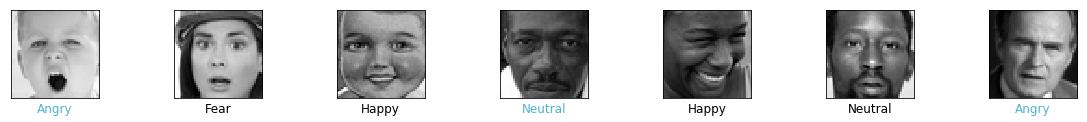

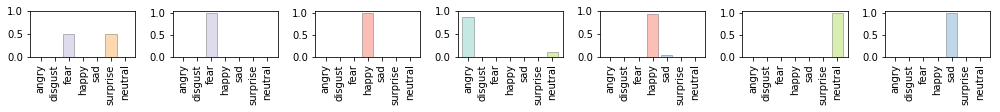

In [28]:
plot_subjects_with_probs(0, 36, test_data_x, y_prob)

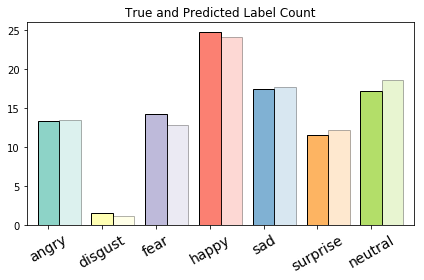

In [29]:
def plot_distribution(y_true, y_pred):
    ind = np.arange(1,8,1)  # the x locations for the groups
    width = 0.4
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true) / len(y_true) * 100, width, color=set3, alpha=1.0, edgecolor='black', linewidth=1)
    pred = ax.bar(ind + width, np.bincount(y_pred) / len(y_pred) * 100, width, color=set3, alpha=0.3, edgecolor='black', linewidth=1)
    ax.set_xticks(np.arange(1,8,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.5 * width, 8 - 0.5*width])
    ax.set_title('True and Predicted Label Count')
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_true, y_pred)

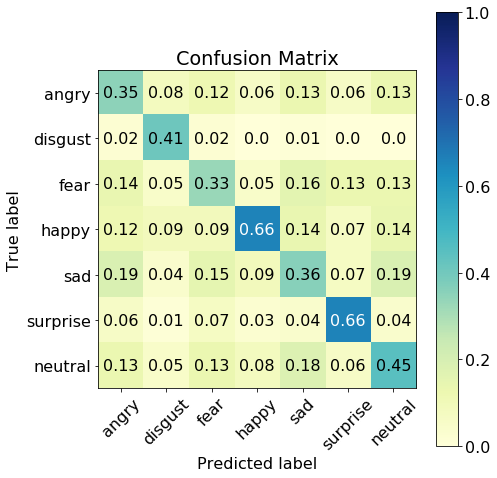

In [30]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:]
    cm = cm.round(2)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    fig.colorbar(matrix) 
    thresh = 0.5
    for i in range(7):
        for j in range(7):  
            ax.text(j,i,cm[i,j],va='center', ha='center', color="white" if cm[i, j] > thresh else "black")
    ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

## Classification Metrics

In [31]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(7)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(7)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(7) if j != i])
    fp = sum([cm[j,i] for j in range(7) if j != i])
    tn = sum([cm[i,j] for j in range(7) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [32]:
for emotion in labels:
    print(emotion)
    print('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

angry
   acc = 0.7905803195962994
  prec = 0.3509865005192108
recall = 0.35281837160751567

disgust
   acc = 0.9831791421362489
  prec = 0.5679012345679012
recall = 0.4144144144144144

fear
   acc = 0.7846930193439865
  prec = 0.3611713665943601
recall = 0.3251953125

happy
   acc = 0.8035323801513877
  prec = 0.6751445086705202
recall = 0.6583990980834273

sad
   acc = 0.728511354079058
  prec = 0.3556254917387884
recall = 0.3624699278267843

surprise
   acc = 0.8973927670311186
  prec = 0.6259977194982896
recall = 0.6606498194945848

neutral
   acc = 0.7559293523969722
  prec = 0.41829085457271364
recall = 0.45255474452554745



In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       0.35      0.35      0.35       958
    disgust       0.57      0.41      0.48       111
       fear       0.36      0.33      0.34      1024
      happy       0.68      0.66      0.67      1774
        sad       0.36      0.36      0.36      1247
   surprise       0.63      0.66      0.64       831
    neutral       0.42      0.45      0.43      1233

avg / total       0.48      0.48      0.48      7178



In [34]:
n = len(y_true)
y_fir = []
y_sec = []
y_trd = []
for i in range(n):
    if y_true[i] == np.argsort(y_prob[i])[-1]:
        y_fir.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-2]:
        y_sec.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-3]:
        y_trd.append([i, y_true[i]])
print(float(len(y_fir))/n)
print(float(len(y_sec))/n)
print(float(len(y_trd))/n)

0.4797993870158819
0.17302869880189467
0.12440791306770688


In [35]:
misclass = [float(len(y_fir))/n, float(len(y_sec))/n, float(len(y_trd))/n]

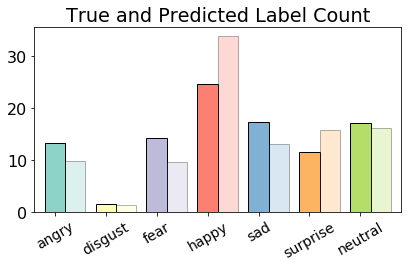

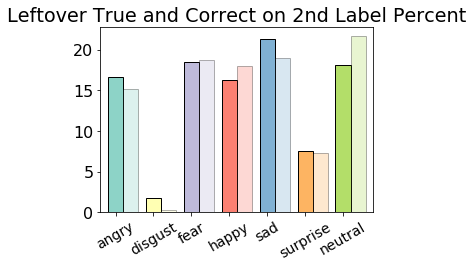

In [36]:
def plot_distribution_second(y_true, y_pred):
    ind = np.arange(1,8,1)  # the x locations for the groups
    width = 0.4
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true) / len(y_true) * 100, width, color=set3, alpha=1.0, edgecolor='black', linewidth=1)
    pred = ax.bar(ind + width, np.bincount(y_pred) / len(y_pred) * 100, width, color=set3, alpha=0.3, edgecolor='black', linewidth=1)
    ax.set_xticks(np.arange(1,8,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.5 * width, 8 - 0.5*width])
    ax.set_title('Leftover True and Correct on 2nd Label Percent')
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_true, [y_true[i] for i in range(len(y_true)) if y_true[i] == y_pred[i]])
plot_distribution_second([y_true[i] for i in range(len(y_true)) if y_true[i] != y_pred[i]], [pair[1] for pair in y_sec])

In [37]:
from sklearn.metrics import hamming_loss
hamming_loss(y_true, y_pred)

0.52020061298411813

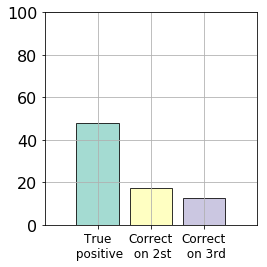

In [38]:
def plot_misclass_distribution(y, tags): 
    fig = plt.figure(figsize=(4,4))
    ax1 = fig.add_subplot(1,1,1)
    ax1.bar(np.arange(1,len(y)+1), np.array(y)*100, color=set3, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_xticks(np.arange(1,len(y)+1,1))
    ax1.set_xticklabels(tags, rotation=0, fontsize=12)
    ax1.set_xlim([0, len(y)+1])
    ax1.set_ylim([0,100])
    ax1.grid(True)
    ax1.set_title('')
    plt.tight_layout()
    plt.show()
tags = ['True\n positive','Correct\n on 2st','Correct\n on 3rd']
plot_misclass_distribution(misclass, tags)